# Decadal variablility of GMM in PCA space on reanalysis datasets

In [1]:
from importlib import reload
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy as ctp
import seaborn as sns
from sklearn import mixture, decomposition

from latgmm.utils import utenso, preproc, eof, utdata, utstats, metric
import latgmm.geoplot as gpl

plt.style.use("../paper.mplstyle")

In [2]:
# Load weights
weight_month_mean = xr.open_dataset(
    "../output/pcgmm/pcgmm_weights_month_sst.nc"
)['p_c_given_x']
gmm_order = weight_month_mean.attrs['gmm_sort']

In [3]:
# Average weights over Dec-Jan-Feb
weight_events = []
for y in np.unique(weight_month_mean.time.dt.year):
    event = weight_month_mean.sel(time=slice(f"{y}-12-01", f"{y+1}-02-28")).mean(dim='time')
    event['time'] = np.datetime64(f"{y}-12-01", 'M')
    weight_events.append(
        event
    )
weight_events = xr.concat(weight_events, dim='time')

/tmp/ipykernel_65650/2730025450.py:5: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  event['time'] = np.datetime64(f"{y}-12-01", 'M')
/tmp/ipykernel_65650/2730025450.py:5: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to n

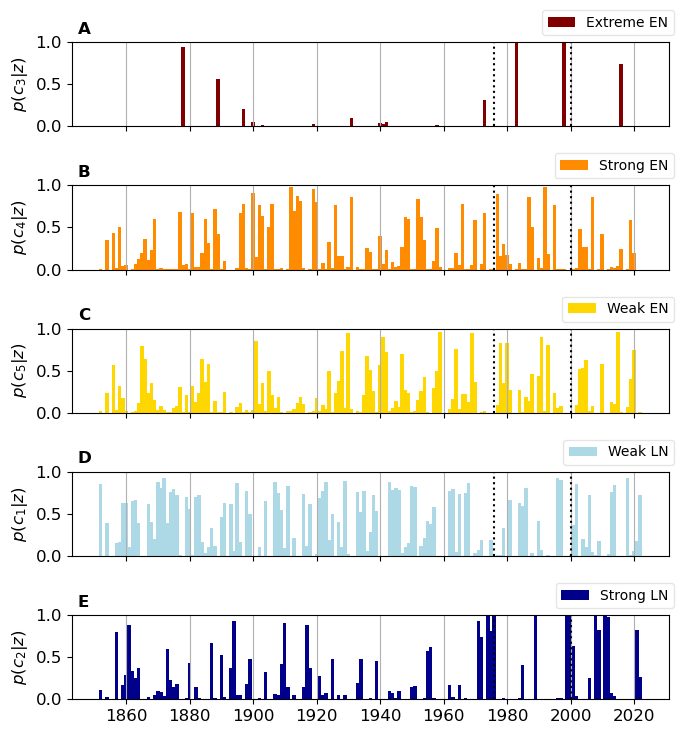

In [7]:
#  Plot posterior weights
class_names = ['Extreme EN', 'Strong EN', 'Weak EN', 'Weak LN', 'Strong LN',]
gmclrs = ['maroon', 'darkorange', 'gold', 'lightblue', 'darkblue', 'black']
n_samples, n_classes = weight_events.shape
fig, axs = plt.subplots(n_classes, 1, figsize=(7, 1.5*n_classes), sharex='col', sharey='row')

for i, k in enumerate(gmm_order):
    axs[i].bar(weight_events['time'].data, height=weight_events.sel(classes=k+1),
                 width=4e2, color=gmclrs[i], label=class_names[i])
    axs[i].grid(axis='x', which='major', linestyle='-')
    axs[i].set_ylabel(rf'$p(c_{k+1}|z)$')
    axs[i].set_ylim([0,1])
    axs[i].set_yticks([0, .5, 1])
    axs[i].legend(bbox_to_anchor=(.72, 1.0, 0.3, 0.1), loc="lower right", fontsize=10)

    axs[i].axvline(np.datetime64('1976-01-01'), ls=':', color='k')
    axs[i].axvline(np.datetime64('2000-01-01'), ls=':', color='k')

gpl.enumerate_subplots(axs, pos_x=0.01, pos_y=1.1, fontsize=12)
plt.savefig("../output/plots/pcgmm_weights.pdf", bbox_inches="tight")